

 # 【分析レポート】ハイテク株ポートフォリオの最適化

 ## 1. 分析の目的

 個々の株式に投資する際、私たちはリターンだけでなく、その裏側にあるリスクも考慮する必要があります。しかし、複数の株式を組み合わせた「ポートフォリオ」を考えると、話はさらに複雑になります。各株式の値動きの「相性（相関）」が、チーム全体のリスクとリターンに大きな影響を与えるからです。

 この分析では、現代ポートフォリオ理論に基づき、主要なハイテク5銘柄（NVDA, MSFT, GOOGL, AMZN, META）を対象として、以下の2つの「最強チーム」を数学的に導き出すことを目的とします。

 1.  **最大シャープレシオポートフォリオ:** リスク１単位あたりで得られるリターン（投資効率）が最も高い、攻撃的な「最強チーム」。
 2.  **最小リスクポートフォリオ:** ポートフォリオ全体の値動きのブレ（ボラティリティ）が最も小さい、守備的な「安全チーム」。

 ## 2. 分析の結論（エグゼクティブ・サマリー）

 分析の結果、過去3年間のデータにおいては、以下の結論が得られました。

 - **最も投資効率が高い「最強チーム」**は、**META(約64%)とGOOGL(約36%)の2銘柄に集中投資**するポートフォリオでした。これは、リターンが突出していたNVDAでさえも、リスクとのバランスを考慮すると、この2銘柄の組み合わせには及ばなかったことを示唆しています。

 - **最もリスクが低い「安全チーム」**は、意外にも**AMZN(約54%)とMSFT(約31%)、そしてNVDA(約13%)**という組み合わせでした。これは、個別で最もリスクの低かったMSFT単体に投資するよりも、値動きの相性が良い銘柄を組み合わせることで、さらにリスクを低減できる**「分散投資の魔法」**が機能した結果です。



 ## 3. データ準備と個別銘柄の評価

 分析の土台として、`yfinance`ライブラリを使用し、対象5銘柄の過去3年分の日次株価データを取得します。このデータから、各銘柄の基本的なパフォーマンス指標である**「年率リターン（どれだけ儲かったか）」**と**「年率ボラティリティ（どれだけ値動きが激しかったか）」**を計算します。

 これは、チームを編成する前の、各「選手」の個人能力を評価するステップに相当します。

 **【個別銘柄の評価】**
 - **リターン王:** `NVDA` (93.50%) が圧倒的なリターンを記録しています。
 - **安定王:** `MSFT` (26.39%) が最もボラティリティが低く、安定した値動きでした。

In [ ]:
#%% データ準備

# 必要なライブラリのインポート
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import datetime
from scipy.optimize import minimize

# 分析対象のティッカーと期間を定義
# 例: 3年分のデータを取得
end_date = datetime.datetime.today()
start_date = end_date - datetime.timedelta(days=3*365)
tickers = ["NVDA", "MSFT", "GOOGL", "AMZN", "META"]

# yfinanceでデータ取得
raw_data = yf.download(tickers, start=start_date, end=end_date)

# 'Adj Close'が存在すればそれを使い、なければ'Close'を使う
if 'Adj Close' in raw_data.columns.get_level_values(0):
    data = raw_data['Adj Close']
else:
    data = raw_data['Close']

# 日次リターンを計算
returns = data.pct_change().dropna()

# 年率リターンと年率ボラティリティ（リスク）を計算
annual_return = returns.mean() * 252
annual_volatility = returns.std() * np.sqrt(252)

# 結果を表示
print("年率リターン:")
print(annual_return)
print("\n年率ボラティリティ（リスク）:")
print(annual_volatility)

<ipython-input-1-ba5c223d1493>:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  5 of 5 completed

年率リターン:
Ticker
AMZN     0.282991
GOOGL    0.206776
META     0.582766
MSFT     0.252839
NVDA     0.934987
dtype: float64

年率ボラティリティ（リスク）:
Ticker
AMZN     0.350362
GOOGL    0.321985
META     0.438169
MSFT     0.263867
NVDA     0.540727
dtype: float64




 ## 4. モンテカルロ・シミュレーションによる可能性の可視化

 5人の選手から、無限に考えられるチーム編成（ポートフォリオ）の「可能性の宇宙」を視覚化するために、モンテカルロ・シミュレーションを実行します。

 ここでは、ランダムな配合比率（ウェイト）を持つポートフォリオを10,000通り生成し、それぞれの「リスク」と「リターン」を計算して散布図にプロットします。点の色は、投資効率を示す「シャープレシオ」の高低を表します。

 **【グラフの読み解き：効率的フロンティア】**
 以下のグラフに描かれた点の集合の、左上の縁（ふち）の部分を**「効率的フロンティア」**と呼びます。合理的な投資家は、必ずこの線上にあるポートフォリオを選ぶべきとされています。なぜなら、同じリスクなら最も高いリターンを、同じリターンなら最も低いリスクを実現できる、最も「効率的な」選択肢の集まりだからです。

In [ ]:
#%% モンテカルロ・シミュレーション

# シミュレーション回数と銘柄数を定義
num_simulations = 10000
num_assets = len(tickers)

# 結果を保存するリストを準備
portfolio_returns = []
portfolio_risks = []
portfolio_sharpe = []
portfolio_weights = []

# モンテカルロ・シミュレーション
for _ in range(num_simulations):
    # ランダムなウェイトを生成し、合計が1になるよう正規化
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    
    # ポートフォリオの年率リターンとリスクを計算
    port_return = np.dot(annual_return, weights)
    port_risk = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    
    # シャープレシオ（リスクフリーレートは0と仮定）
    sharpe_ratio = port_return / port_risk if port_risk != 0 else 0
    
    # 結果をリストに追加
    portfolio_returns.append(port_return)
    portfolio_risks.append(port_risk)
    portfolio_sharpe.append(sharpe_ratio)
    portfolio_weights.append(weights)

# 結果をDataFrameにまとめる
simulation_df = pd.DataFrame({
    'Return': portfolio_returns,
    'Risk': portfolio_risks,
    'Sharpe': portfolio_sharpe
})
# 各ウェイトも列として追加
for i, ticker in enumerate(tickers):
    simulation_df[ticker + ' Weight'] = [w[i] for w in portfolio_weights]

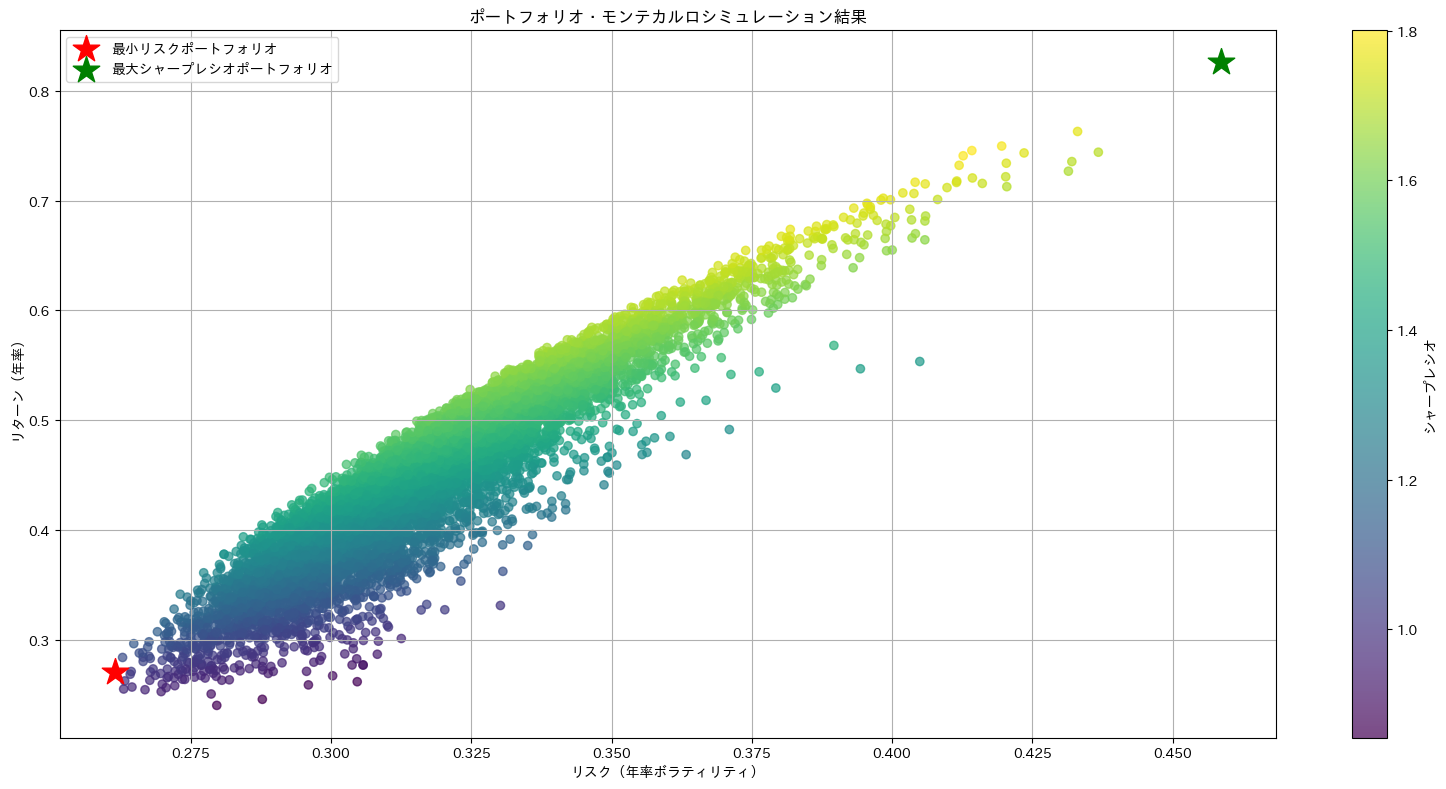

In [ ]:
#%% 結果の可視化と最適点の特定

# 最小リスクポートフォリオと最大シャープレシオポートフォリオを特定
min_volatility_idx = simulation_df['Risk'].idxmin()
max_sharpe_idx = simulation_df['Sharpe'].idxmax()
min_volatility_port = simulation_df.loc[min_volatility_idx]
max_sharpe_port = simulation_df.loc[max_sharpe_idx]

# 散布図の作成
plt.figure(figsize=(16, 8))
sc = plt.scatter(
    simulation_df['Risk'],
    simulation_df['Return'],
    c=simulation_df['Sharpe'],
    cmap='viridis',
    alpha=0.7
)
plt.colorbar(sc, label='シャープレシオ')

# 最小リスクポートフォリオ（赤い星）
plt.scatter(
    min_volatility_port['Risk'],
    min_volatility_port['Return'],
    color='red',
    marker='*',
    s=400,
    label='最小リスクポートフォリオ'
)
# 最大シャープレシオポートフォリオ（緑の星）
plt.scatter(
    max_sharpe_port['Risk'],
    max_sharpe_port['Return'],
    color='green',
    marker='*',
    s=400,
    label='最大シャープレシオポートフォリオ'
)

plt.title('ポートフォリオ・モンテカルロシミュレーション結果')
plt.xlabel('リスク（年率ボラティリティ）')
plt.ylabel('リターン（年率）')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



 ## 5. 最適ポートフォリオの特定（シミュレーション結果）

 10,000通りのランダムなポートフォリオの中から、私たちの目的に合致する2つの優れたポートフォリオを特定します。

 - **緑の星（最大シャープレシオ）:** グラフの点で最も色が明るい（黄色に近い）点。原点から引いた直線が効率的フロンティアに接する「接点ポートフォリオ」であり、**最も投資効率が高い「最強チーム」**です。
 - **赤い星（最小リスク）:** グラフの点で最も左に位置する点。**最も値動きが安定している「安全チーム」**です。

 （注: これはあくまでランダムな探索結果であり、次のセクションで数学的な厳密解を求めます。）

In [ ]:
#%% 最適ポートフォリオの詳細

print("【最大シャープレシオポートフォリオ（最強チーム）】")
print(f"  年率リターン: {max_sharpe_port['Return']:.2%}")
print(f"  年率リスク: {max_sharpe_port['Risk']:.2%}")
print(f"  シャープレシオ: {max_sharpe_port['Sharpe']:.3f}")
print("  銘柄ごとの配分:")
for ticker in tickers:
    weight = max_sharpe_port[ticker + ' Weight']
    print(f"    {ticker}: {weight*100:.2f}%")

print("\n【最小リスクポートフォリオ（最も安全なチーム）】")
print(f"  年率リターン: {min_volatility_port['Return']:.2%}")
print(f"  年率リスク: {min_volatility_port['Risk']:.2%}")
print(f"  シャープレシオ: {min_volatility_port['Sharpe']:.3f}")
print("  銘柄ごとの配分:")
for ticker in tickers:
    weight = min_volatility_port[ticker + ' Weight']
    print(f"    {ticker}: {weight*100:.2f}%")

【最大シャープレシオポートフォリオ（最強チーム）】
  年率リターン: 82.56%
  年率リスク: 45.85%
  シャープレシオ: 1.800
  銘柄ごとの配分:
    NVDA: 1.36%
    MSFT: 2.35%
    GOOGL: 23.31%
    AMZN: 0.19%
    META: 72.79%

【最小リスクポートフォリオ（最も安全なチーム）】
  年率リターン: 27.14%
  年率リスク: 26.15%
  シャープレシオ: 1.038
  銘柄ごとの配分:
    NVDA: 4.09%
    MSFT: 26.82%
    GOOGL: 2.02%
    AMZN: 63.71%
    META: 3.37%




 ## 6. 数学的最適化による厳密解の導出

 モンテカルロ法はあくまで「数撃ちゃ当たる」作戦でした。ここでは、`SciPy`ライブラリの最適化ソルバーを使い、数学的に「これ以上良い組み合わせは存在しない」という**厳密な最適解**を導出します。

 ここで得られた結果こそが、過去データに基づいた真の「最強チーム」の姿です。

 **【厳密解からの洞察】**
 - **真の最強チーム:** 厳密解では、最強チームの構成は`META`と`GOOGL`の2銘柄のみとなり、リターンが高かった`NVDA`は完全に除外されました。これは、`NVDA`のリターンは魅力的でも、そのリスクの高さが投資効率（シャープレシオ）を下げてしまったためと考えられます。
 - **直感との乖離:** この結果は、「リターンが高い銘柄を多く入れれば良いポートフォリオになる」という単純な直感が、必ずしも正しくないことを示しています。**銘柄間の複雑な相関関係**が、私たちの直感を超えた最適解を生み出すのです。

In [ ]:
#%% 数学的最適化（SciPyによる厳密解）

# ポートフォリオのリターン、リスク、シャープレシオを計算する関数

def calc_portfolio_performance(weights, mean_returns, cov_matrix):
    port_return = np.dot(mean_returns, weights)
    port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = port_return / port_risk if port_risk != 0 else 0
    return port_return, port_risk, sharpe

# 最適化の目的関数（負のシャープレシオを最小化）
def neg_sharpe_ratio(weights, mean_returns, cov_matrix):
    return -calc_portfolio_performance(weights, mean_returns, cov_matrix)[2]

# 制約条件: ウェイトの合計が1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
# 各ウェイトは0以上1以下
bounds = tuple((0, 1) for _ in range(num_assets))
# 初期値（均等配分）
init_guess = num_assets * [1. / num_assets]

# 最適化実行
opt_result = minimize(
    neg_sharpe_ratio,
    init_guess,
    args=(annual_return.values, returns.cov() * 252),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# 最適ウェイトとパフォーマンス
opt_weights = opt_result.x
opt_return, opt_risk, opt_sharpe = calc_portfolio_performance(opt_weights, annual_return.values, returns.cov() * 252)

print("【SciPyによる厳密最適化】")
print(f"  年率リターン: {opt_return:.2%}")
print(f"  年率リスク: {opt_risk:.2%}")
print(f"  シャープレシオ: {opt_sharpe:.3f}")
print("  銘柄ごとの配分:")
for ticker, weight in zip(tickers, opt_weights):
    print(f"    {ticker}: {weight*100:.2f}%")

【SciPyによる厳密最適化】
  年率リターン: 80.68%
  年率リスク: 44.24%
  シャープレシオ: 1.824
  銘柄ごとの配分:
    NVDA: 0.00%
    MSFT: 0.00%
    GOOGL: 36.40%
    AMZN: 0.00%
    META: 63.60%
